In [1]:
from patchify import patchify, unpatchify
# Useful Imports
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn as nn
from torch.autograd import Variable
import pandas as pd
import os,sys
import io
from PIL import Image
import tensorflow as tf
from IPython.display import clear_output
import tensorflow_datasets as tfds
import tensorflow.io as tfio
from glob import glob
import time
import datetime
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import *
from keras.layers import *

%load_ext autoreload
%autoreload 2



In [2]:


def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

#Load test images
root_dir = "test_set/"
image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(20, len(files)) # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])



#n = 10 # Only use 10 images for training


Loading 20 images
test_14.png


In [3]:
# Divide into patches

patch_size = 128
step_size = 120
img_patches = np.asarray([patchify(imgs[i], (patch_size, patch_size,3),step_size) for i in range(n)])
imgs = np.asarray(imgs)
print("Large image shape is: ", imgs.shape)
print("Patches array shape is: ", img_patches.shape)
print(np.max(imgs))
img_patches = np.squeeze(img_patches,axis = 3)
print("Patches array shape is: ", img_patches.shape)

Large image shape is:  (20, 608, 608, 3)
Patches array shape is:  (20, 5, 5, 1, 128, 128, 3)
1.0
Patches array shape is:  (20, 5, 5, 128, 128, 3)


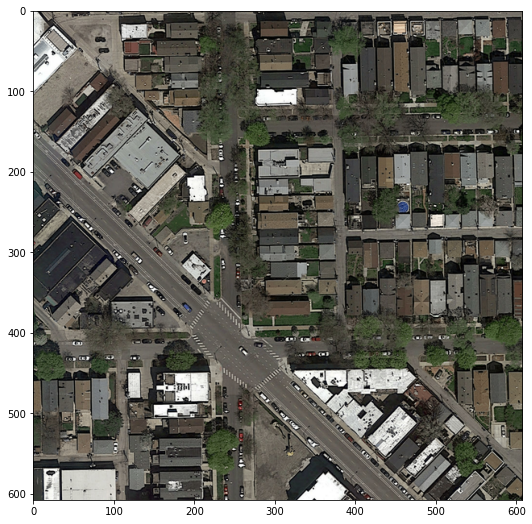

In [4]:
plt.figure(figsize=(9, 9))
plt.imshow(imgs[0], cmap='gray')

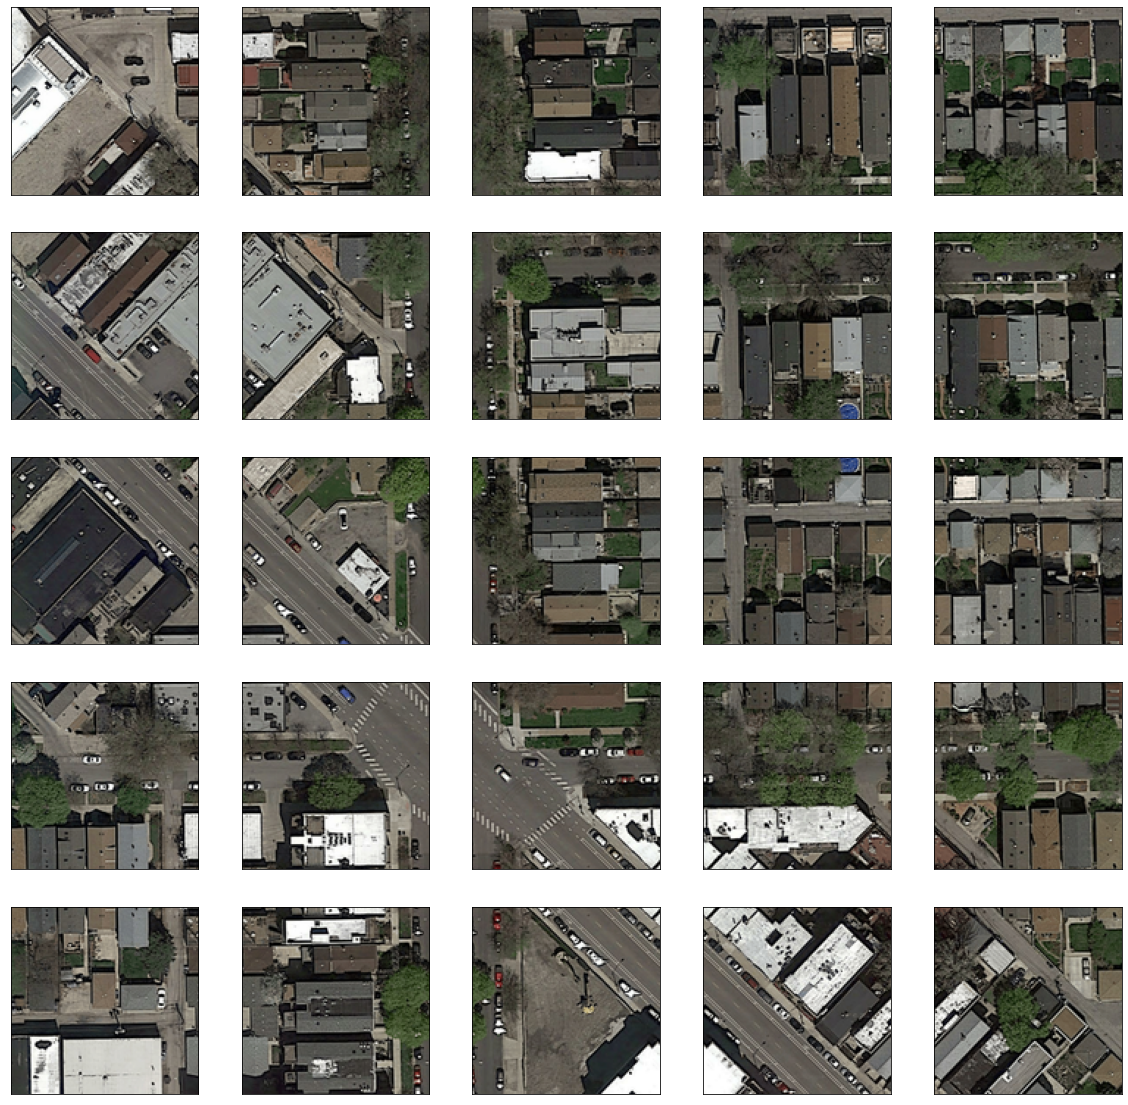

In [5]:
plt.figure(figsize=(20, 20))
square = 5
ix = 1

i=0
for j in range(square):
	for k in range(square):
		# specify subplot and turn of axis
		ax = plt.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot 
		plt.imshow(img_patches[i, j, k, :, :, :])
		ix += 1
# show the figure
plt.show()

In [6]:
print("Image data shape is: ", img_patches.shape)
print("Max pixel value in image is: ", img_patches.max())

Image data shape is:  (20, 5, 5, 128, 128, 3)
Max pixel value in image is:  1.0


In [7]:
from keras.models import load_model
model = load_model("Saved_models/unet_train_1.hdf5", compile=False)

2021-12-06 10:14:49.354884: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
#Apply a trained model on large image, patch by patch
img_predict_patch = []
for i in range(img_patches.shape[0]):
    for j in range(img_patches.shape[1]):
        for k in range(img_patches.shape[2]):
            print("Now predicting on patch", i,j,k)
        
            patch = img_patches[i,j,k,:,:,:]  

            
            patch_input=np.expand_dims(patch, 0)
            patch_prediction = (model.predict(patch_input)[0,:,:,0] > 0.5).astype(np.uint8)

            img_predict_patch.append(patch_prediction)

img_predict_patch = np.array(img_predict_patch)


Now predicting on patch 0 0 0
Now predicting on patch 0 0 1
Now predicting on patch 0 0 2
Now predicting on patch 0 0 3
Now predicting on patch 0 0 4
Now predicting on patch 0 1 0
Now predicting on patch 0 1 1
Now predicting on patch 0 1 2
Now predicting on patch 0 1 3
Now predicting on patch 0 1 4
Now predicting on patch 0 2 0
Now predicting on patch 0 2 1
Now predicting on patch 0 2 2
Now predicting on patch 0 2 3
Now predicting on patch 0 2 4
Now predicting on patch 0 3 0
Now predicting on patch 0 3 1
Now predicting on patch 0 3 2
Now predicting on patch 0 3 3
Now predicting on patch 0 3 4
Now predicting on patch 0 4 0
Now predicting on patch 0 4 1
Now predicting on patch 0 4 2
Now predicting on patch 0 4 3
Now predicting on patch 0 4 4
Now predicting on patch 1 0 0
Now predicting on patch 1 0 1
Now predicting on patch 1 0 2
Now predicting on patch 1 0 3
Now predicting on patch 1 0 4
Now predicting on patch 1 1 0
Now predicting on patch 1 1 1
Now predicting on patch 1 1 2
Now predic

In [10]:
img_predict_patch = np.reshape(img_predict_patch,(img_patches.shape[0],img_patches.shape[1],img_patches.shape[2], 128,128) )
img_predict_patch.shape

(20, 5, 5, 128, 128)

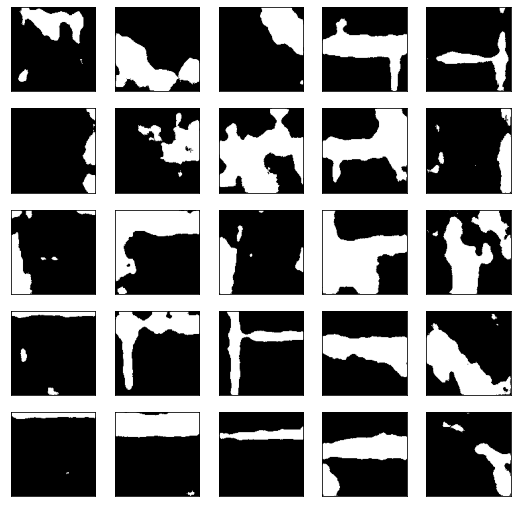

In [11]:
plt.figure(figsize=(9, 9))
square = 5
ix = 1

i=0
for k in range(square):
	for j in range(square):
		# specify subplot and turn of axis
		ax = plt.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot 
		plt.imshow(img_predict_patch[i, j, k, :, :], cmap='Greys_r')
		ix += 1
# show the figure
plt.show()

In [24]:
## Reconstruct full image

reconstructed_img  = [unpatchify(img_predict_patch[i],(608,608)) for i in range(n)]

#Patchify 16X16
submit_patches = np.asarray(([patchify(reconstructed_img[i], (16, 16)) for i in range(n)]))

In [25]:
print(submit_patches.shape)

(20, 593, 593, 16, 16)


In [28]:
submit_patches_list = []
for i in range(submit_patches.shape[0]):
    for j in range(submit_patches.shape[1]):
        for k in range(submit_patches.shape[2]):
            submit_patches_list.append(submit_patches[i,j,k,:,:])
        
submit_patches_list = np.asarray(submit_patches_list)


In [30]:
print(submit_patches_list.shape)
submit_patches_list = np.expand_dims(submit_patches_list, axis = 3)
print(submit_patches_list.shape)

(7032980, 16, 16)
(7032980, 16, 16, 1)
